In [1]:
%%capture
%pip install transformers datasets

In [2]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt

from transformers import DistilBertTokenizer

import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch import optim
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset

from tqdm.notebook import tqdm
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## DATASET
The classification task will be done on the IMDB review Dataset. Reviews are either labeled "positive" or "negative". The reviews are also quite long on average, so it will be a good opportunity to observe the performance gained on computation time using Linformer. 

In [3]:
from datasets import load_dataset
import unicodedata
import re
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained(
    "distilbert-base-uncased", do_lower_case=True
)
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)
print(dataset[0])

C:\Users\1411\anaconda3\envs\env_name\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})
{'review': "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are 

In [4]:
def preprocessing_fn(x, tokenizer):
    x["input_ids"] = tokenizer.encode(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=1024,
        padding=True,
        return_attention_mask=False,
    )
    x['label']=1 if x['sentiment']=='positive' else 0
    return x

In [5]:
n_samples = 50000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select n_samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)

# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["input_ids", "label"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]


Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = self.tokenizer.pad(
            batch, padding="longest", max_length=1024, return_tensors="pt"
        )
        return features

data_collator = DataCollator(tokenizer)

In [7]:
batch_size = 32

train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator, shuffle=True
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)



## Model Implementation

#### Feed-Forward

In [8]:
class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(FeedForward, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),  
            nn.Dropout(dropout),  
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)

#### Classic Multi-Head Self-Attention 

In [9]:
class Multi_Head_Attention(nn.Module):
    def __init__(self, d, n_heads, dropout=0.3):
        super().__init__()
        assert d % n_heads == 0, "Embedding dimension must be divisible by the number of heads"
        
        self.n_heads = n_heads
        self.d_heads = d // n_heads  # Dimension per head

        self.q_proj = nn.Linear(d, d, bias=False)
        self.k_proj = nn.Linear(d, d, bias=False)
        self.v_proj = nn.Linear(d, d, bias=False)
        self.out_proj = nn.Linear(d, d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len, d = x.shape
        d_heads = self.d_heads

        # Linear projections
        q = self.q_proj(x).reshape(batch_size, seq_len, self.n_heads, d_heads).transpose(1, 2)  # (B, H, L, D_head)
        k = self.k_proj(x).reshape(batch_size, seq_len, self.n_heads, d_heads).transpose(1, 2)  # (B, H, L, D_head)
        v = self.v_proj(x).reshape(batch_size, seq_len, self.n_heads, d_heads).transpose(1, 2)  # (B, H, L, D_head)

        # Attention scores
        score = torch.softmax(q @ k.transpose(-1, -2) * (d_heads**-0.5), dim=-1)
        score = self.dropout(score)  # Apply dropout to attention scores

        # Attention output
        attention = score @ v  # (B, H, L, D_head)
        attention = attention.transpose(1, 2).reshape(batch_size, seq_len, d)  # Merge heads

        # Output projection
        attention = self.out_proj(attention)  # Project back to original embedding dimension
        return attention

#### Linformer Multi-Head Self-Attention

In [10]:
class LinearAttentionHead(nn.Module):
    def __init__(self, dim, dropout, input_size, dim_k):
        super(LinearAttentionHead, self).__init__()
        self.E = nn.Parameter(torch.randn(input_size, dim_k))
        self.F = nn.Parameter(torch.randn(input_size, dim_k))
        nn.init.xavier_uniform_(self.E)
        nn.init.xavier_uniform_(self.F)
        self.dim = dim
        self.dropout = nn.Dropout(dropout)

    def forward(self, Q, K, V):
        
        batch_size, n_heads, seq_len, d_heads = Q.shape

        E = self.E[:seq_len, :].to(K.device)  # Adjust to seq_len
        F = self.F[:seq_len, :].to(V.device)  # Adjust to seq_len

        # Project K and V
        K = K.transpose(-2, -1)  # (batch_size, n_heads, d_heads, seq_len)
        K = K @ E  # (batch_size, n_heads, d_heads, k_dim)
        V = V.transpose(-2, -1)  # (batch_size, n_heads, d_heads, seq_len)
        V = V @ F  # (batch_size, n_heads, d_heads, k_dim)

        # Compute attention scores
        Q = Q @ K  # (batch_size, n_heads, seq_len, k_dim)
        P_bar = Q / torch.sqrt(torch.tensor(self.dim, dtype=Q.dtype).to(Q.device))
            
        P_bar = P_bar.softmax(dim=-1)
        P_bar = self.dropout(P_bar)

        # Apply attention scores to V
        out = P_bar @ V.transpose(-2, -1)  # (batch_size, n_heads, seq_len, d_heads)
        return out


class MHAttention(nn.Module):
    def __init__(self, input_size, d_heads, d, dim_k, n_heads, dropout):
        super(MHAttention, self).__init__()
        
        self.n_heads = n_heads
        self.d_heads = d_heads
        self.dim_k = dim_k
        self.d = d
        self.w_o = nn.Linear(d_heads * n_heads, d)

        # Define query, key, value projection layers
        self.to_q = nn.Linear(d, d_heads * n_heads, bias=False)
        self.to_k = nn.Linear(d, d_heads * n_heads, bias=False)
        self.to_v = nn.Linear(d, d_heads * n_heads, bias=False)
        self.mh_dropout = nn.Dropout(dropout)

        # Create a single LinearAttentionHead for all heads
        self.attention_head = LinearAttentionHead(d_heads, dropout, input_size, dim_k)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        # Project input to queries, keys, values
        Q = self.to_q(x).view(batch_size, seq_len, self.n_heads, self.d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)
        K = self.to_k(x).view(batch_size, seq_len, self.n_heads, self.d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)
        V = self.to_v(x).view(batch_size, seq_len, self.n_heads, self.d_heads).transpose(1, 2)  # (batch_size, n_heads, seq_len, d_heads)
        
        # Compute attention
        out = self.attention_head(Q, K, V)  # (batch_size, n_heads, seq_len, d_heads)

        # Merge heads and project to output
        out = out.transpose(1, 2).reshape(batch_size, seq_len, -1)  # (batch_size, seq_len, d_heads * n_heads)
        out = self.w_o(out)
        out = self.mh_dropout(out)
        return out

#### Transformer Layer and Architecture

In [11]:
class TransformerLayer(nn.Module):
    def __init__(self, d, d_ff, seq_len, k_dim, dropout=0.3, n_heads=8, Linformer_Mode=False):
        super().__init__()
        if Linformer_Mode:
            self.attention = MHAttention(
                input_size=seq_len+1, #+1 For the CLS Token
                d_heads=d // n_heads, 
                d=d,  
                dim_k=k_dim,  
                n_heads=n_heads,  
                dropout=dropout
            )
        else:
            self.attention = Multi_Head_Attention(d,n_heads, dropout)

        self.feedforward = FeedForward(d, d_ff, d, dropout=dropout)
        self.pre_attention_norm = nn.LayerNorm(d)
        self.post_attention_norm = nn.LayerNorm(d)

    def forward(self, x):
        # Attention with residual connection
        normed_x = self.pre_attention_norm(x)
        if isinstance(self.attention, MHAttention):
            attention = self.attention(normed_x)  # Linformer attention
        else:
            attention = self.attention(normed_x)  # Classic Transformer attention
        y = normed_x + attention

        # Feedforward with residual connection
        normed_y = self.post_attention_norm(y)
        ff_y = self.feedforward(normed_y)
        return normed_y + ff_y


class Transformer_Classif(nn.Module):
    def __init__(self, d, d_ff, n_classes, vocab_size, max_len=512, k_dim=128, drop=0.3, num_layers=4, n_heads=8, Linformer_Mode=False):
        super().__init__()
        self.wordembeddings = nn.Embedding(vocab_size, d)
        self.position_embeddings = nn.Embedding(num_embeddings=max_len+1, embedding_dim=d)  
        self.cls_token = nn.Parameter(torch.randn(1, 1, d))  # Classification token
        self.dropout = nn.Dropout(drop)

        # Stack of Transformer or Linformer layers
        self.transformer_layers = nn.ModuleList([
            TransformerLayer(d, d_ff, max_len, k_dim, drop, n_heads, Linformer_Mode=Linformer_Mode) for _ in range(num_layers)
        ])
        self.out_norm = nn.LayerNorm(d)
        self.classif = nn.Linear(d, n_classes)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        # Word and positional embeddings
        X = self.wordembeddings(x)  # (B, L, d)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        position_vectors = self.position_embeddings(positions)  # (B, L, d)
        X = self.dropout(X + position_vectors)

        # Add classification token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # (B, 1, d)
        X = torch.cat((cls_tokens, X), dim=1)  # (B, L, d)

        # Loop over Transformer or Linformer layers
        for layer in self.transformer_layers:
            X = layer(X)

        # Extract [CLS] token representation
        cls_representation = X[:, 0]  # (B, d)

        # Classification layer
        logits = self.classif(cls_representation)  # (B, n_classes)
        return logits

#### Testing : 

In [12]:
seq_len = 512
batch_size = 8
vocab_size = 30522

x = torch.randint(0, vocab_size, (batch_size, seq_len))

model = Transformer_Classif(
    d=128,
    d_ff=4*128,
    n_classes=2,
    vocab_size=30522,
    max_len=512,
    k_dim=0,
    drop=0.2,
    num_layers=1,
    n_heads=8,
    Linformer_Mode = False
)

logits = model(x)
print("Logits shape:", logits.shape)  # Expected: (batch_size, n_classes)
print("Logits:", logits)

Logits shape: torch.Size([8, 2])
Logits: tensor([[0.5525, 0.1794],
        [0.4824, 0.2336],
        [0.4508, 0.0317],
        [0.4356, 0.0838],
        [0.5110, 0.0014],
        [0.4659, 0.0672],
        [0.5763, 0.1575],
        [0.4629, 0.0798]], grad_fn=<AddmmBackward0>)


In [13]:
seq_len = 512
batch_size = 8
vocab_size = 30522

x = torch.randint(0, vocab_size, (batch_size, seq_len))

model = Transformer_Classif(
    d=128,
    d_ff=4*128,
    n_classes=2,
    vocab_size=30522,
    max_len=512,
    k_dim=128,
    drop=0.2,
    num_layers=1,
    n_heads=8,
    Linformer_Mode = True
)

logits = model(x)
print("Logits shape:", logits.shape)  # Expected: (batch_size, n_classes)
print("Logits:", logits)

Logits shape: torch.Size([8, 2])
Logits: tensor([[0.4777, 0.3438],
        [0.5692, 0.3559],
        [0.4700, 0.3098],
        [0.5291, 0.4171],
        [0.4240, 0.3586],
        [0.5470, 0.2366],
        [0.5167, 0.2690],
        [0.4090, 0.4188]], grad_fn=<AddmmBackward0>)


## Training

In [14]:
def compute_accuracy(predictions, labels):
    pred = predictions.argmax(dim=1)  # (batch_size,)
    # Compare with true class indices
    correct = (labels == pred).sum().item()
    return correct

def train_one_epoch(dataloader, model, optimizer, loss_function):
    model.train()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    for batch in tqdm(dataloader, leave=True):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        probs = model(batch["input_ids"])  # (batch_size, n_classes)
        gold = batch["label"]  # (batch_size,)

        correct += compute_accuracy(probs, gold)
        loss = loss_function(probs, gold) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_train  
    return avg_loss, avg_accuracy


def validation_step(dataloader,model, loss_function):
    model.eval()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    with torch.no_grad():
        for batch in tqdm(dataloader, leave=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            probs = model(batch["input_ids"])
            gold = batch["label"]

            correct += compute_accuracy(probs, gold)
            loss = loss_function(probs, gold)
            total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_valid  
    return avg_loss, avg_accuracy

def train(model, train_dataloader, valid_dataloader, lr=0.0005, n_epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Track training loss, training accuracy, validation loss and validation accuracy and plot in the end
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train_one_epoch(
            train_dataloader, model, optimizer, criterion
        )
        valid_loss, valid_accuracy = validation_step(valid_dataloader, model, criterion)
        print(
            f"Epoch {epoch + 1}: train_loss: {train_loss:.4f}, train_accuracy: {train_accuracy:.4f}, valid_loss: {valid_loss:.4f}, valid_accuracy: {valid_accuracy:.4f}"
        )
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="train loss")
    plt.plot(valid_losses, label="valid loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label="train accuracy")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

### Classic Transformer training

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.5498, train_accuracy: 70.5800, valid_loss: 0.4221, valid_accuracy: 80.7300


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.3974, train_accuracy: 82.0875, valid_loss: 0.3504, valid_accuracy: 84.9400


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.3384, train_accuracy: 85.3750, valid_loss: 0.3246, valid_accuracy: 86.2900


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: train_loss: 0.2997, train_accuracy: 87.1525, valid_loss: 0.2990, valid_accuracy: 87.5600


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: train_loss: 0.2727, train_accuracy: 88.6625, valid_loss: 0.3044, valid_accuracy: 87.8900


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: train_loss: 0.2496, train_accuracy: 89.7875, valid_loss: 0.3052, valid_accuracy: 88.0400


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: train_loss: 0.2305, train_accuracy: 90.5625, valid_loss: 0.3073, valid_accuracy: 87.4800


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: train_loss: 0.2120, train_accuracy: 91.4500, valid_loss: 0.2922, valid_accuracy: 88.4100


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: train_loss: 0.1916, train_accuracy: 92.4350, valid_loss: 0.3024, valid_accuracy: 88.9700


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: train_loss: 0.1786, train_accuracy: 92.9425, valid_loss: 0.3184, valid_accuracy: 88.7300
Time to train : 1107.32s


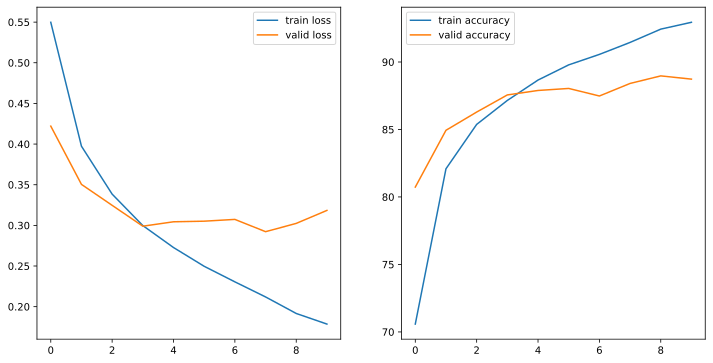

In [15]:
# Initialize model
model_classic = Transformer_Classif(
    d=256,
    d_ff=4*256,
    n_classes=2,
    vocab_size=30522,
    max_len=1024,
    k_dim=0,
    drop=0.1,
    num_layers=2,
    n_heads=4,
    Linformer_Mode = False
)
model_classic.to(device)

#Training + computation time recording
start_time = time.time()
if __name__ == '__main__':
    train(model_classic, train_dataloader, valid_dataloader,lr=0.0002, n_epochs=10)
end_time = time.time()
loop_time = (end_time - start_time)
print(f"Time to train : {loop_time:.2f}s")

### Linformer training

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1: train_loss: 0.6557, train_accuracy: 58.0650, valid_loss: 0.5077, valid_accuracy: 75.8000


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2: train_loss: 0.4664, train_accuracy: 77.9200, valid_loss: 0.3840, valid_accuracy: 82.8900


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3: train_loss: 0.3750, train_accuracy: 83.2125, valid_loss: 0.3374, valid_accuracy: 86.0300


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 4: train_loss: 0.3285, train_accuracy: 85.8750, valid_loss: 0.3257, valid_accuracy: 86.3800


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 5: train_loss: 0.2893, train_accuracy: 87.9200, valid_loss: 0.3225, valid_accuracy: 86.8900


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 6: train_loss: 0.2566, train_accuracy: 89.3875, valid_loss: 0.3146, valid_accuracy: 87.7200


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 7: train_loss: 0.2303, train_accuracy: 90.7200, valid_loss: 0.3154, valid_accuracy: 88.1600


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 8: train_loss: 0.2177, train_accuracy: 91.1800, valid_loss: 0.3203, valid_accuracy: 88.3100


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 9: train_loss: 0.1968, train_accuracy: 92.0800, valid_loss: 0.4140, valid_accuracy: 87.7800


  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch 10: train_loss: 0.1761, train_accuracy: 92.9800, valid_loss: 0.3540, valid_accuracy: 87.8500
Time to train : 765.94s


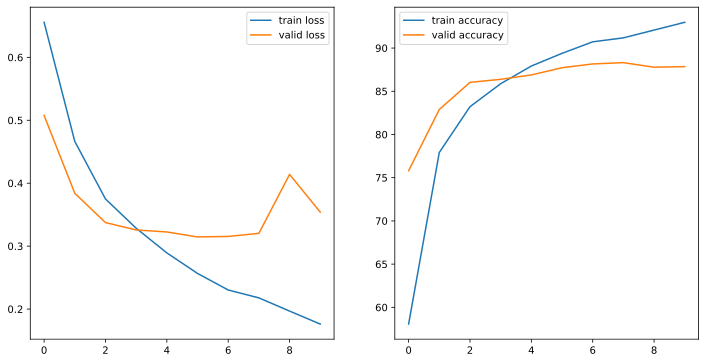

In [16]:
# Initialize model
model_Linformer = Transformer_Classif(
    d=256,
    d_ff=4*256,
    n_classes=2,
    vocab_size=30522,
    max_len=1024,
    k_dim=256,
    drop=0.15,
    num_layers=2,
    n_heads=4,
    Linformer_Mode = True
)
model_Linformer.to(device)

#Training + computation time recording
start_time = time.time()
if __name__ == '__main__':
    train(model_Linformer, train_dataloader, valid_dataloader,lr=0.0002, n_epochs=10)
end_time = time.time()
loop_time = (end_time - start_time)
print(f"Time to train : {loop_time:.2f}s")

### Conclusion : 

We can see that Linformer has roughly the same performance as the Transformer model. On the other hand, Linformer reduces computation time by more than 30% ! 